In [211]:
# !pip install torchinfo
# !pip install tensorflow
# !pip install keras
# !pip install --upgrade openpyxl
# !pip install pandas

(1007, 993)


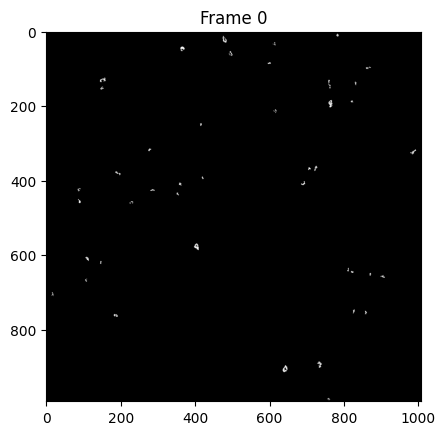

(1007, 993)


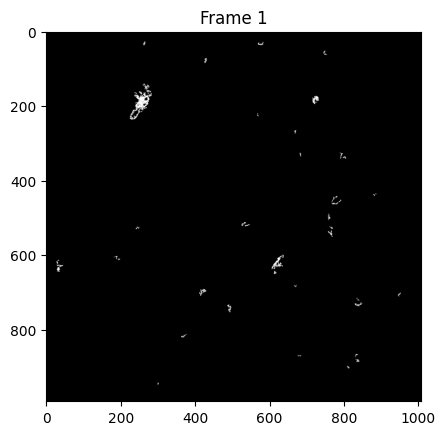

(1007, 993)


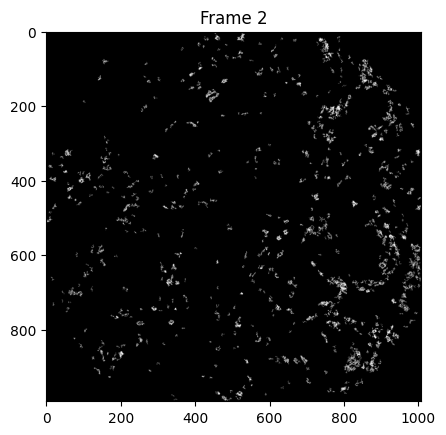

(1007, 993)


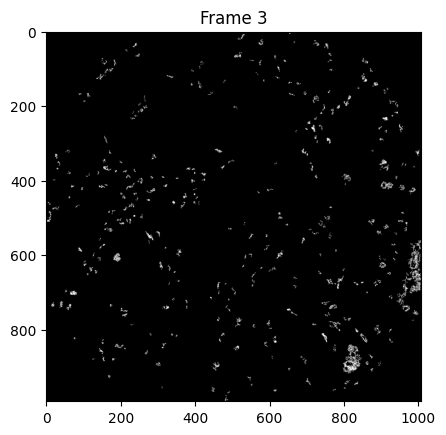

(1007, 993)


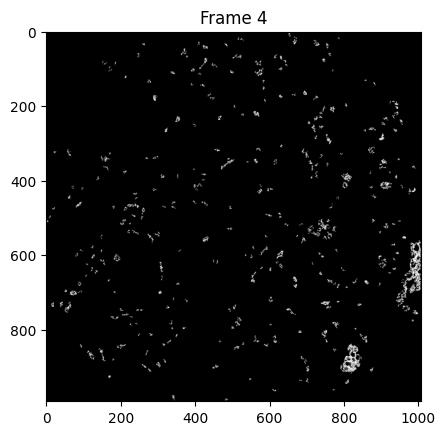

(1007, 993)


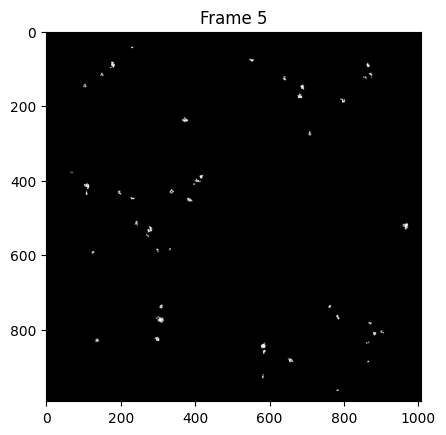

(1007, 993)


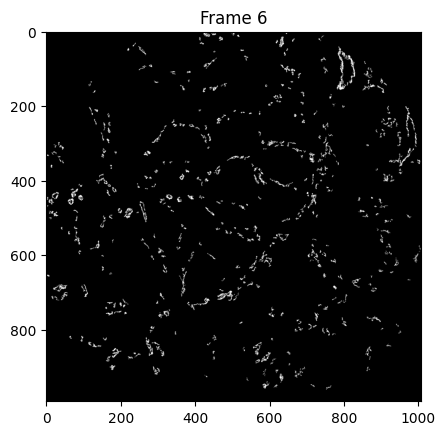

(1007, 993)


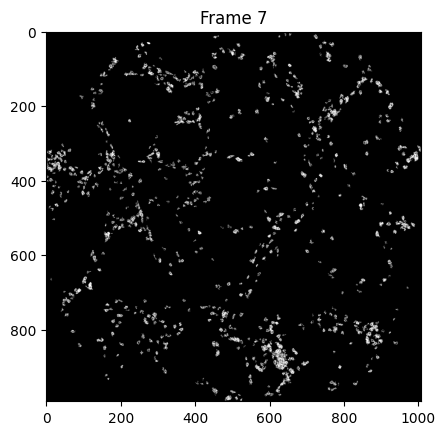

(1007, 993)


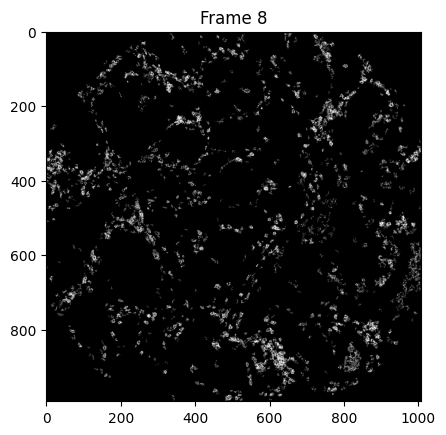

(1007, 993)


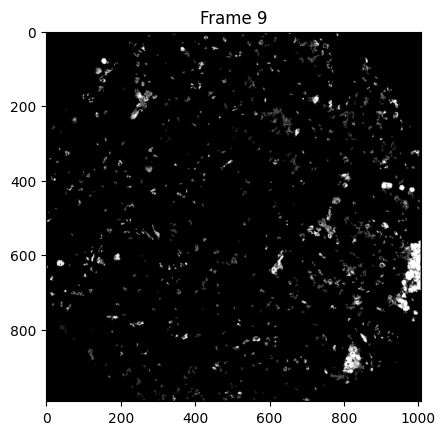

(1007, 993)


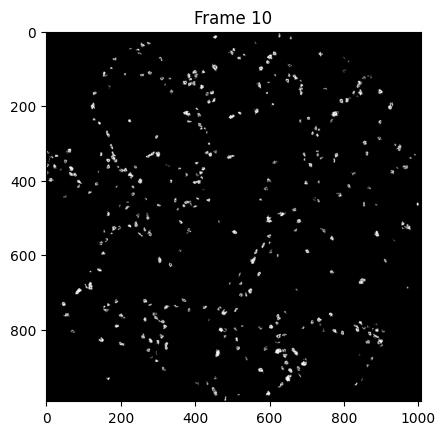

(1007, 993)


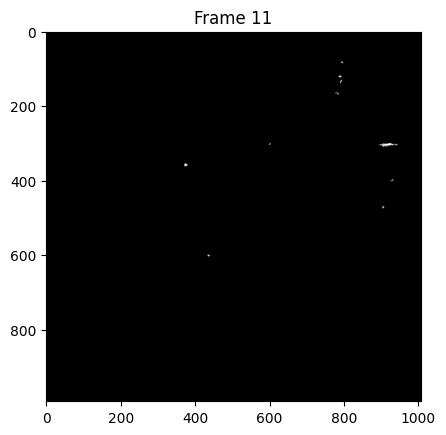

(1007, 993)


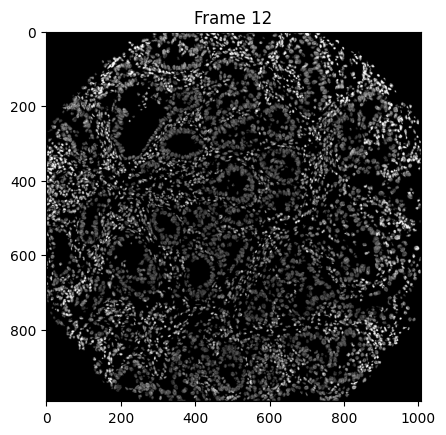

(1007, 993)


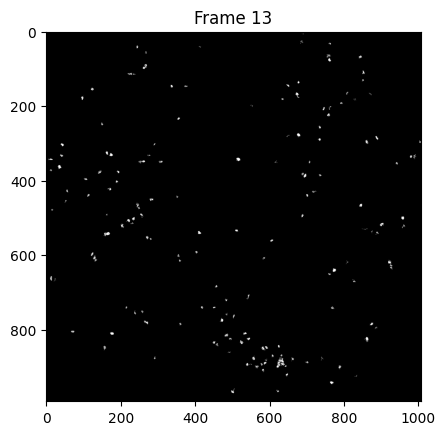

(1007, 993)


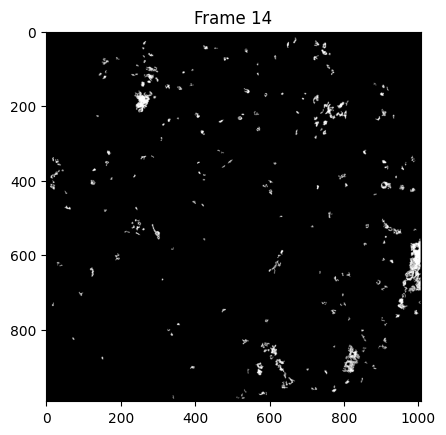

(1007, 993)


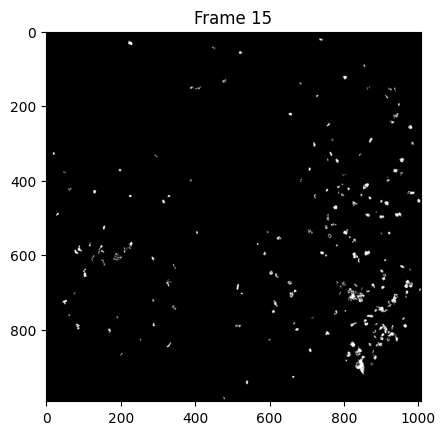

(1007, 993)


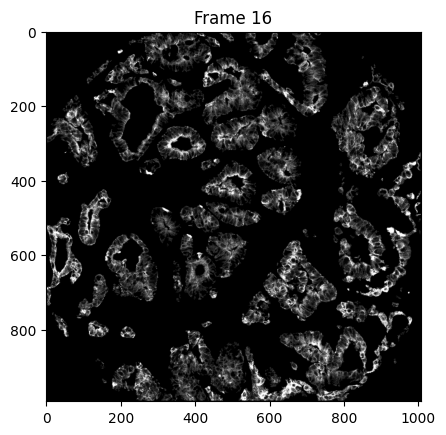

(1007, 993)


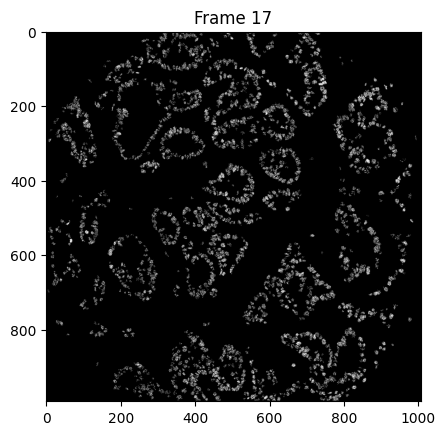

In [212]:
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt

# Open the multi-frame TIFF file
with Image.open('LungData/LUAD_IMC_MaskTif/LUAD_D001.tif') as img:
    # Loop over each frame in the image
    for i, frame in enumerate(ImageSequence.Iterator(img)):
        print(frame.size)
        # Display the frame using matplotlib
        plt.figure()
        plt.imshow(frame, cmap='gray')
        plt.title(f'Frame {i}')
        plt.show()

In [213]:
def my_tiff_loader(filename):
  head_tail = os.path.split(filename)
  filenameWithTiff = head_tail[-1]
  
  fileNameToBeUsed = filenameWithTiff[0:-(len('.tiff'))]
  folder_path = RAW_Image_Source_Folder+fileNameToBeUsed+'/'
  for i in range(len(channel_names)):
    if i==0:
      im = Image.open(folder_path+channel_names[i]+'.png')
      image = im.resize([224,224])
      image = np.expand_dims(image,0).astype(np.float32)
    else:
      im = Image.open(folder_path+channel_names[i]+'.png')
      next_channel = im.resize([224,224])
      next_channel = np.expand_dims(next_channel,0).astype(np.float32)
      image = np.concatenate((image,next_channel),0)

  return image



In [214]:
# channel_names = ['aSMA','Arg1','B7-H3','B7-H4','BCL2','CD3','CD4','CD8a','CD11c','CD14','CD16','CD20','CD31','CD39','CD40','CD45','CD68','CD94','CD117','CD163','Cleaved Caspase3','DNA1','DNA2','FoxP3','HIF-1a','Histone H3','HLA-DR','Ki67','MCSFR','MMP9','MPO','Pancytokeratin','PD1','PDL1-Biotin','pERK','pSTAT3','TTF1']
# len(channel_names)
# import pandas as pd
# clinical_variables = pd.read_excel('./LungData/LUAD Clinical Data.xlsx')
# clinical_variables.head()

In [215]:
import torchvision
import torch.nn as nn
from functools import partial
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resnet_models = {18: torchvision.models.resnet18,
                 34: torchvision.models.resnet34,
                 50: torchvision.models.resnet50,
                 101: torchvision.models.resnet101,
                 152: torchvision.models.resnet152}

class Resnet_multichannel(nn.Module):
    def __init__(self, pretrained=True, encoder_depth=34, num_in_channels=4):
        super().__init__()
        
        if encoder_depth not in [18, 34, 50, 101, 152]:
            raise ValueError(f"Encoder depth {encoder_depth} specified does not match any existing Resnet models")
            
        model = resnet_models[encoder_depth](pretrained)
        
        ##For reference: layers to use (in order):
        # conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, avgpool, fc
        
        # This is the most important line of code here. This increases the number of in channels for our network
        self.conv1 = self.increase_channels(model.conv1, num_in_channels)
        # self.conv1 = model.conv1
        
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4
        self.avgpool = model.avgpool
        # self.fc = model.fc
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        # x = self.fc(x)
        return x
        
    def increase_channels(self, m, num_channels=None, copy_weights=0):


        """
        takes as input a Conv2d layer and returns the a Conv2d layer with `num_channels` input channels
        and all the previous weights copied into the new layer.
        """
        # number of input channels the new module should have
        new_in_channels = num_channels if num_channels is not None else m.in_channels + 1
        
        bias = False if m.bias is None else True
        
        # Creating new Conv2d layer
        new_m = nn.Conv2d(in_channels=new_in_channels, 
                          out_channels=m.out_channels, 
                          kernel_size=m.kernel_size, 
                          stride=m.stride, 
                          padding=m.padding,
                          bias=bias)
        
        # Copying the weights from the old to the new layer
        new_m.weight.data[:, :m.in_channels, :, :] = m.weight.clone()
        
        #Copying the weights of the `copy_weights` channel of the old layer to the extra channels of the new layer
        for i in range(new_in_channels - m.in_channels):
            channel = m.in_channels + i
            new_m.weight.data[:, channel:channel+1, :, :] = m.weight[:, copy_weights:copy_weights+1, : :].clone()
        new_m.weight = nn.Parameter(new_m.weight)

        return new_m
    
def get_arch(encoder_depth, num_in_channels):
    """
    Returns just an architecture which can then be called in the usual way.
    For example:
    resnet34_4_channel = get_arch(34, 4)
    model = resnet34_4_channel(True)
    """
    return partial(Resnet_multichannel, encoder_depth=encoder_depth, num_in_channels=num_in_channels)

In [216]:
resnet50_mchannel = get_arch(50, 3)

model = resnet50_mchannel(True) 
print("New input channels : ", model.conv1.in_channels)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New input channels :  3


In [217]:
from torchinfo import summary

In [218]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [219]:
feature_extract = True
set_parameter_requires_grad(model, feature_extract)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)
input_size = 224

In [220]:
print(summary(model))

Layer (type:depth-idx)                   Param #
Resnet_multichannel                      --
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  (4,096)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─Conv2d: 3-3                  (36,864)
│    │    └─BatchNorm2d: 3-4             (128)
│    │    └─Conv2d: 3-5                  (16,384)
│    │    └─BatchNorm2d: 3-6             (512)
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              (16,896)
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  (16,384)
│    │    └─BatchNorm2d: 3-10            (128)
│    │    └─Conv2d: 3-11                 (36,864)
│    │    └─BatchNorm2d: 3-12            (128)
│    │    └─C

## Create embeddings with ResNet

In [228]:
# test for inference
import PIL.Image as Image
import torchvision.transforms as transforms
to_tensor = transforms.ToTensor()


def get_embedding_from_tif(tif_file_path, channel_indices):
  model.eval()

  # Open the TIFF file
  with Image.open(tif_file_path) as img:
    
    # Save the embeddings from each channel in a list
    output_embeddings = []
    
    # Loop over the images in the TIFF file
    for index, image in enumerate(ImageSequence.Iterator(img)):
      
      # Only used images from the selected channels
      if index in channel_indices:
        image = image.resize([224, 224])
        tensor_im = to_tensor(image)
        tensor_im = tensor_im.repeat(3, 1, 1)
        tensor_im = torch.unsqueeze(tensor_im, 0)
        # print(tensor_im.shape)
        out = model(tensor_im)
        output_embeddings.append(out)
    
    return torch.cat(output_embeddings, 1)

final_output_embedding = get_embedding_from_tif('LungData/LUAD_IMC_MaskTif/LUAD_D001.tif', range(18))

print(final_output_embedding.shape)
print(final_output_embedding)
print(final_output_embedding.shape)

torch.Size([1, 36864])
tensor([[0.2853, 0.0026, 0.0309,  ..., 0.1947, 0.0000, 0.0581]])
torch.Size([1, 36864])


In [231]:
# This function corresponds to def read_variable_file_check_examples(file_path, mother_examples)

def get_patient_key_and_progression_values(file_path, progression_column):
    # Load data from the specified Excel file
    df = pd.read_excel(file_path)
    
    # Remove any trailing whitespace in column names
    df.columns = df.columns.str.strip()
    
    # Filter the DataFrame for non-null entries in the specified progression column
    filtered_df = df[df[progression_column].notnull()]

    # Convert the progression values to integers
    filtered_df[progression_column] = filtered_df[progression_column].astype(int)
    
    # Extract the 'Key' values and the specified progression column values as lists
    patient_key = filtered_df['Key'].tolist()
    progression_values = filtered_df[progression_column].tolist()
    
    # Return the patient_key and their corresponding progression values
    return patient_key, progression_values

file_path = './LungData/LUAD Clinical Data.xlsx'
progression_column = 'Progression (No: 0, Yes: 1)'
patient_keys, progression_labels = get_patient_key_and_progression_values(file_path, progression_column)
print(f'Length of patient_key: {len(patient_keys)}, progression: {len(progression_labels)}')

Length of patient_key: 404, progression: 404


/var/folders/p9/37n8_h0j3w136cfjm88xkpcr0000gn/T/ipykernel_11234/2191048005.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[progression_column] = filtered_df[progression_column].astype(int)


In [246]:
# TODO Create X
all_embeddings = []
for index, key in enumerate(patient_keys):
    final_output_embedding = get_embedding_from_tif(f'LungData/LUAD_IMC_MaskTif/{key}.tif', range(18))
    all_embeddings.append(final_output_embedding)
    print(f'Key: {key}, Shape: {final_output_embedding.shape}')

all_embeddings_tensor = torch.cat(all_embeddings, 0)
all_embeddings_numpy = torch.Tensor.numpy(all_embeddings_tensor)
print(all_embeddings_numpy.shape)

Key: LUAD_D001, Shape: torch.Size([1, 36864])
Key: LUAD_D002, Shape: torch.Size([1, 36864])
Key: LUAD_D003, Shape: torch.Size([1, 36864])
Key: LUAD_D004, Shape: torch.Size([1, 36864])
Key: LUAD_D005, Shape: torch.Size([1, 36864])
Key: LUAD_D006, Shape: torch.Size([1, 36864])
Key: LUAD_D007, Shape: torch.Size([1, 36864])
Key: LUAD_D008, Shape: torch.Size([1, 36864])
Key: LUAD_D009, Shape: torch.Size([1, 36864])
Key: LUAD_D010, Shape: torch.Size([1, 36864])
Key: LUAD_D011, Shape: torch.Size([1, 36864])
Key: LUAD_D012, Shape: torch.Size([1, 36864])
Key: LUAD_D013, Shape: torch.Size([1, 36864])
Key: LUAD_D014, Shape: torch.Size([1, 36864])
Key: LUAD_D015, Shape: torch.Size([1, 36864])
Key: LUAD_D016, Shape: torch.Size([1, 36864])
Key: LUAD_D017, Shape: torch.Size([1, 36864])
Key: LUAD_D018, Shape: torch.Size([1, 36864])
Key: LUAD_D019, Shape: torch.Size([1, 36864])
Key: LUAD_D020, Shape: torch.Size([1, 36864])
Key: LUAD_D021, Shape: torch.Size([1, 36864])
Key: LUAD_D022, Shape: torch.Size(

In [277]:
# np.savetxt("embeddings_18_markers.csv", all_embeddings_numpy, delimiter=",")
X = all_embeddings_numpy

In [278]:
# TODO Create y
y = np.array(progression_labels)
y.shape

(404,)

In [279]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

X.shape, y.shape

((680, 36864), (680,))

In [282]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,random_state=10,shuffle=True)
for train_index, test_index in kf.split(X):
    print(f'X, train: {X[train_index].shape}, test: {X[test_index].shape}')
    print(f'y, train: {y[train_index].shape}, test: {y[test_index].shape}')

X, train: (544, 36864), test: (136, 36864)
y, train: (544,), test: (136,)
X, train: (544, 36864), test: (136, 36864)
y, train: (544,), test: (136,)
X, train: (544, 36864), test: (136, 36864)
y, train: (544,), test: (136,)
X, train: (544, 36864), test: (136, 36864)
y, train: (544,), test: (136,)
X, train: (544, 36864), test: (136, 36864)
y, train: (544,), test: (136,)


In [290]:
from sklearn.decomposition import MiniBatchSparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

delete_dup = True

for k, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # # Remove duplicates
    # toBeDeleted = []
    # if delete_dup:
    #   for i in range(X_test.shape[0]):
    #     query = X_test[i]
    #     j = 0
    #     query_found = 0
    #     while j < X_train.shape[0] and query_found==0:
    #       match = X_train[j]
    #       dist = np.linalg.norm(query-match)
    #       if dist == 0:
    #         query_found = 1
    #         toBeDeleted.append(i)
    #       j = j + 1

    #   if X_test.shape[0]-len(toBeDeleted) >= 5:
    #     X_test = np.delete(X_test,np.s_[toBeDeleted],axis=0)
    #     y_test = np.delete(y_test,np.s_[toBeDeleted],axis=0)

    # Principal Component Analysis
    transformer = MiniBatchSparsePCA(n_components=9, batch_size=500,random_state=0)
    transformer.fit(X_train)
    X_tr_em = transformer.transform(X_train)
    X_te_em = transformer.transform(X_test)

    # Support Vector Machine classifier
    kernel = 1.0 * RBF(1.0)
    clf = make_pipeline(StandardScaler(), SVC(gamma=1e1,C=1e1,kernel = kernel))
    clf.fit(X_tr_em, y_train)
    y_pred = clf.predict(X_te_em)
    print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}')
    print(f'Fold {k+1} test score: {clf.score(X_te_em, y_test)}')

print(f'Baseline: {1 - np.mean(progression_labels)}')

Confusion matrix: 
[[62  6]
 [ 0 68]]
Fold 1 test score: 0.9558823529411765
Confusion matrix: 
[[67  5]
 [ 1 63]]
Fold 2 test score: 0.9558823529411765
Confusion matrix: 
[[65  6]
 [ 0 65]]
Fold 3 test score: 0.9558823529411765
Confusion matrix: 
[[61  3]
 [ 0 72]]
Fold 4 test score: 0.9779411764705882
Confusion matrix: 
[[62  3]
 [ 3 68]]
Fold 5 test score: 0.9558823529411765
Baseline: 0.8415841584158416


In [ ]:
# # Send the model to GPU
# # Detect if we have a GPU available
# import torch.optim as optim
# model = model.to(device)
# params_to_update = model.parameters()
# print("Params to learn:")
# if feature_extract:
#     params_to_update = []
#     for name,param in model.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print("\t",name)
# else:
#     for name,param in model.named_parameters():
#         if param.requires_grad == True:
#             print("\t",name)

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [ ]:
# import time
# import copy

# def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
#     since = time.time()

#     val_acc_history = []
    
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     if is_inception and phase == 'train':                      
#                         outputs, aux_outputs = model(inputs)
#                         loss1 = criterion(outputs, labels)
#                         loss2 = criterion(aux_outputs, labels)
#                         loss = loss1 + 0.4*loss2
#                     else:
#                         outputs = model(inputs)
#                         loss = criterion(outputs, labels)

#                     _, preds = torch.max(outputs, 1)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / len(dataloaders[phase].dataset)
#             epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
#             if phase == 'val':
#                 val_acc_history.append(epoch_acc)
#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model, val_acc_history

In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from pathlib import Path
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# from keras.applications.vgg16 import preprocess_input
from glob import glob
import numpy as np
import pandas as pd
print("done")

done


In [ ]:
source_folder = "./LungData/LungData/LUAD_IMC_MaskTif/"
allExamples = glob(source_folder+"/**/", recursive = True)
print(allExamples)

[]


In [ ]:
df = pd.read_excel(metal_indicator_lung)
channel_names = df.Indicator.values
co_marker = df.Comarker.values
num_channels = len(channel_names)
print(num_channels)
allResponses = np.zeros((len(allExamples),num_channels*2048))

NameError: name 'metal_indicator_lung' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
patient_keys_train, patient_keys_test, progression_labels_train, progression_labels_test = train_test_split(patient_keys, progression_labels, test_size=0.2, random_state=42)

In [ ]:
import os

dir1 = dir_experiment+experiment_name
# dir2 = dir_experiment+experiment_name+"/train/"
# dir3 = dir_experiment+experiment_name+"/val/"

# used = set()
# uniqueLabels = [x for x in aFileNamesLabels if x not in used and (used.add(x) or True)]

# if not os.path.exists(dir_experiment):
#   os.mkdir(dir_experiment)
# if not os.path.exists(dir1):
#   os.mkdir(dir1)
# if not os.path.exists(dir2):
#   os.mkdir(dir2)
# if not os.path.exists(dir3):
#   os.mkdir(dir3)

# for j in range(len(uniqueLabels)):
#   c_dir = dir2+str(uniqueLabels[j])+'/'
#   if not os.path.exists(c_dir):
#     os.mkdir(c_dir)
# for j in range(len(uniqueLabels)):
#   c_dir = dir3+str(uniqueLabels[j])+'/'
#   if not os.path.exists(c_dir):
#     os.mkdir(c_dir)

# for i in range(len(aFileNames_train)):
#   file = dir2+str(aFileNamesLabels_train[i])+'/'+aFileNames_train[i]+'.tiff'
#   open(file, 'a').close()

# for i in range(len(aFileNames_test)):
#   file = dir3+str(aFileNamesLabels_test[i])+'/'+aFileNames_test[i]+'.tiff'
#   open(file, 'a').close()

def my_tiff_loader(filename):
  head_tail = os.path.split(filename)
  filenameWithTiff = head_tail[-1]
  
  fileNameToBeUsed = filenameWithTiff[0:-(len('.tiff'))]
  folder_path = RAW_Image_Source_Folder+fileNameToBeUsed+'/'
  for i in range(len(channel_names)):
    if i==0:
      im = Image.open(folder_path+channel_names[i]+'.png')
      image = im.resize([224,224])
      image = np.expand_dims(image,0).astype(np.float32)
    else:
      im = Image.open(folder_path+channel_names[i]+'.png')
      next_channel = im.resize([224,224])
      next_channel = np.expand_dims(next_channel,0).astype(np.float32)
      image = np.concatenate((image,next_channel),0)

  return image

from torchvision import datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(dir1, x),loader=my_tiff_loader) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

NameError: name 'dir_experiment' is not defined

In [ ]:
test = {x: x + " value" for x in ['train', 'val']}
print(test)

{'train': 'train value', 'val': 'val value'}
